### Import and preprocess the data

In [141]:
import pandas as pd
df = pd.read_excel('Online Retail.xlsx')

In [142]:
df = df.dropna()
df = df[df['Quantity'] > 0]

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [144]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Feature Engineering

In [145]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['Date'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [146]:
customer = df.groupby(['CustomerID', 'Date']).agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalPrice=('TotalPrice', 'sum'),
    InvoiceCount=('InvoiceNo', 'nunique'),
    Country=('Country', 'first'),
).reset_index().sort_values(by=["Date", "CustomerID"]).reset_index(drop=True)

customer['AverageUnitPrice'] = customer['TotalPrice'] / customer['TotalQuantity']

customer['PreviousDate'] = customer.groupby('CustomerID')['Date'].shift(1)
customer['Date'] = pd.to_datetime(customer['Date'], errors='coerce')
customer['PreviousDate'] = pd.to_datetime(customer['PreviousDate'], errors='coerce')

customer['DaysSinceLastPurchase'] = (
    customer['Date'] - customer['PreviousDate']
).apply(lambda x: x.days if pd.notnull(x) else None)

customer['DaysSinceLastPurchase'] = customer['DaysSinceLastPurchase'].fillna(0)

# Remove outliers
customer = customer[customer['AverageUnitPrice'] > 0]
customer = customer[customer['AverageUnitPrice'] < 100]
customer = customer[customer['TotalPrice'] < customer['TotalPrice'].quantile(0.99)]
customer = customer[customer['TotalQuantity'] < customer['TotalQuantity'].quantile(0.99)]

customer.sample(n=5)

,CustomerID,Date,TotalQuantity,TotalPrice,InvoiceCount,Country,AverageUnitPrice,PreviousDate,DaysSinceLastPurchase
1773,16029.0,2011-01-20,309,957.63,2,United Kingdom,3.099126,2011-01-13,7.0
12062,14332.0,2011-10-04,242,466.30,1,United Kingdom,1.926860,2011-07-15,81.0
15395,16352.0,2011-11-22,156,289.52,1,United Kingdom,1.855897,2011-11-02,20.0
4903,17675.0,2011-04-14,244,498.16,1,United Kingdom,2.041639,2011-03-29,16.0
2349,14606.0,2011-02-06,46,94.27,1,United Kingdom,2.049348,2011-02-03,3.0


### Graphical representation of the data

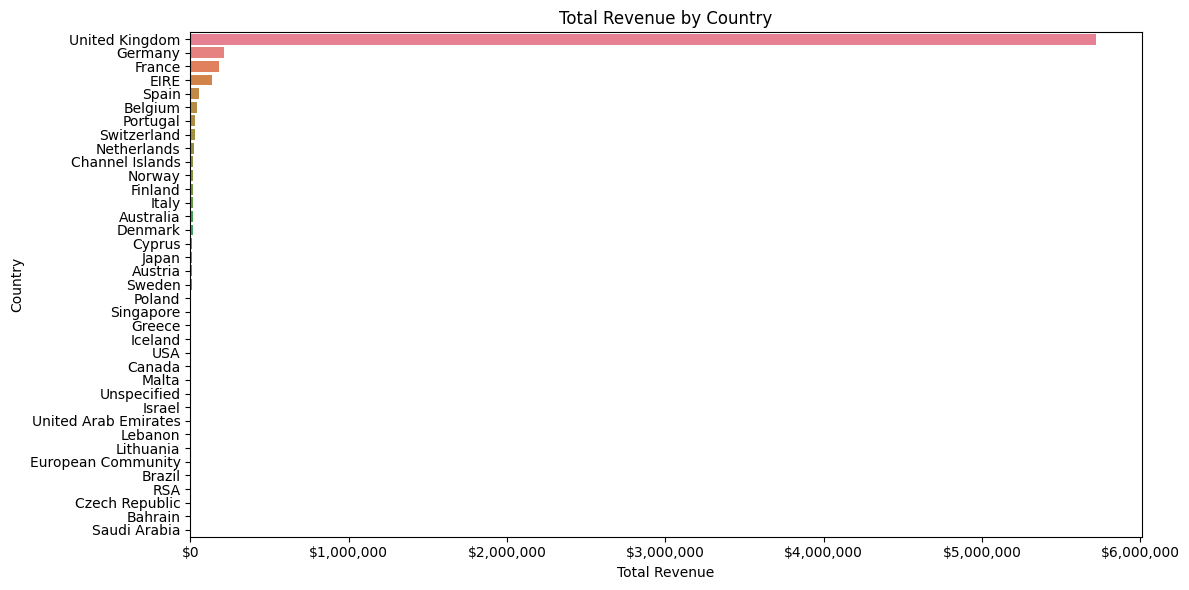

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick


country_revenue = customer.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, hue=country_revenue.index, legend=False)

ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.title('Total Revenue by Country')
plt.xlabel('Total Revenue')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

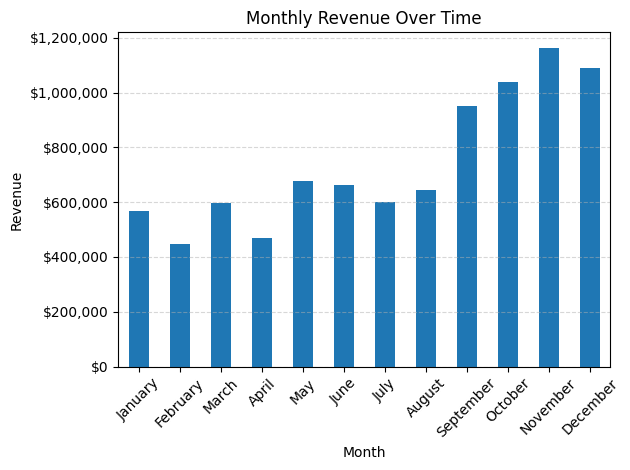

In [148]:
df['Month'] = df['InvoiceDate'].dt.month_name()
monthly_sales = df.groupby('Month')['TotalPrice'].sum().reindex(['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']).reset_index()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar', x='Month', y='TotalPrice', legend=False)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.title('Monthly Revenue Over Time')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Cluster Analysis and modeling

In [149]:
dataset = customer.groupby('CustomerID').agg(
    TotalQuantity=('TotalQuantity', 'sum'),
    TotalPrice=('TotalPrice', 'sum'),
    InvoiceCount=('InvoiceCount', 'sum'),
    AverageRecency=('DaysSinceLastPurchase', 'mean')
).reset_index().sort_values(by='CustomerID').reset_index(drop=True)
dataset['AverageUnitPrice'] = dataset['TotalPrice'] / dataset['TotalQuantity']
dataset.head()

,CustomerID,TotalQuantity,TotalPrice,InvoiceCount,AverageRecency,AverageUnitPrice
0,12347.0,2458,4310.00,7,52.142857,1.753458
1,12348.0,2341,1797.24,4,70.750000,0.767723
2,12349.0,631,1757.55,1,0.000000,2.785341
3,12350.0,197,334.40,1,0.000000,1.697462
4,12352.0,536,2506.04,8,37.142857,4.675448


In [150]:
features = dataset[['TotalQuantity', 'TotalPrice', 'InvoiceCount', 'AverageRecency', 'AverageUnitPrice']]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_df = pd.DataFrame(scaled_features, columns=features.columns, index=dataset.index)

K=1, Inertia=21570.000000000004
K=2, Inertia=16237.002235854197
K=3, Inertia=13025.113401072536
K=4, Inertia=9902.92374532978
K=5, Inertia=8522.473663598703
K=6, Inertia=7603.497659756415
K=7, Inertia=5555.098924188591
K=8, Inertia=4662.380865158595
K=9, Inertia=4223.660607854608
K=10, Inertia=3869.8296980761343


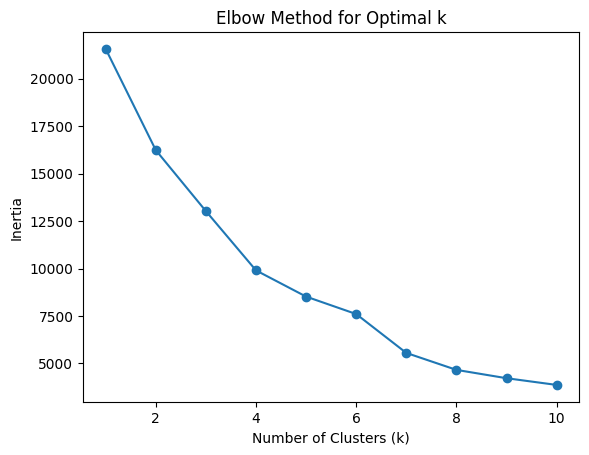

In [151]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    print(f'K={k}, Inertia={kmeans.inertia_}')

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [152]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    print(f"Silhouette Score for k={k}: {score:.3f}")

Silhouette Score for k=2: 0.888
Silhouette Score for k=3: 0.589
Silhouette Score for k=4: 0.415
Silhouette Score for k=5: 0.442
Silhouette Score for k=6: 0.391
Silhouette Score for k=7: 0.400
Silhouette Score for k=8: 0.426
Silhouette Score for k=9: 0.425
Silhouette Score for k=10: 0.420


### Cluster Interpretation & Visualisation (k = 4)

In [153]:
kmeans = KMeans(n_clusters=4, random_state=42)
dataset['Cluster'] = kmeans.fit_predict(scaled_features)

cluster_profiles = dataset.groupby('Cluster').mean(numeric_only=True)

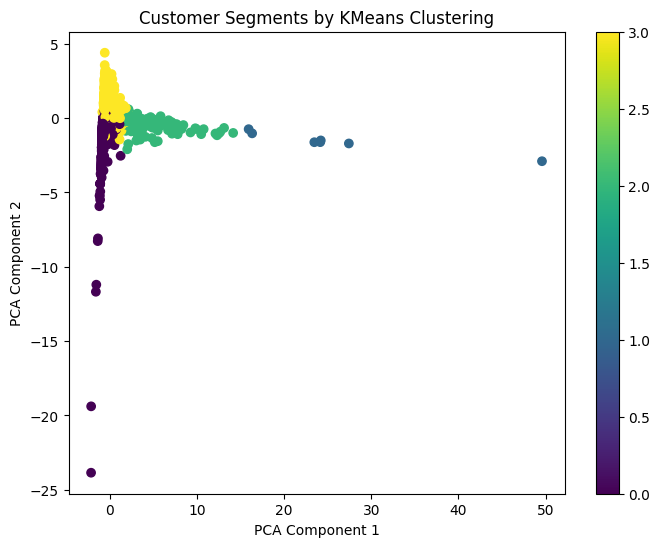

In [154]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

dataset['PCA1'] = pca_components[:, 0]
dataset['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(8,6))
plt.scatter(dataset['PCA1'], dataset['PCA2'], c=dataset['Cluster'], cmap='viridis')
plt.title('Customer Segments by KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

In [155]:
cluster_profiles = dataset.groupby('Cluster')[['TotalQuantity', 'TotalPrice', 'InvoiceCount', 'AverageRecency', 'AverageUnitPrice']].mean().round(3)
cluster_profiles

,TotalQuantity,TotalPrice,InvoiceCount,AverageRecency,AverageUnitPrice
Cluster,,,,,
0,308.268,535.974,1.712,6.089,2.306
1,29277.286,48377.773,112.286,4.794,1.606
2,5003.099,9130.355,19.647,21.828,1.948
3,957.441,1614.967,4.742,65.070,1.898


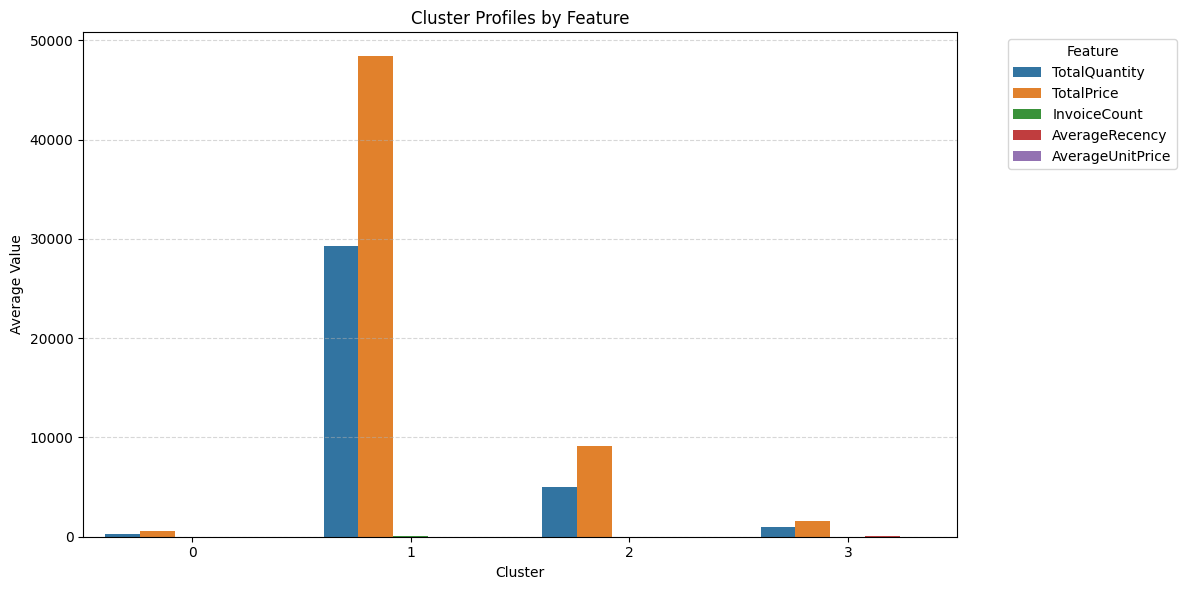

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for average features by cluster
cluster_profiles.index.name = 'Cluster'
long_df = cluster_profiles.reset_index().melt(id_vars='Cluster', var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(data=long_df, x='Cluster', y='Value', hue='Feature')

plt.title("Cluster Profiles by Feature")
plt.ylabel("Average Value")
plt.xlabel("Cluster")
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib

# Fit scaler and model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(scaled_features)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

# Save the trained scaler and model
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')


['kmeans_model.pkl']

In [158]:
scaler = joblib.load('scaler.pkl')
kmeans = joblib.load('kmeans_model.pkl')

# Example input of customer data to predict cluster
input_data = [[400, 800, 2, 15, 1.6]]
scaled_input = scaler.transform(input_data)
cluster = kmeans.predict(scaled_input)

print(f"Predicted Cluster: {cluster[0]}")

Predicted Cluster: 1


In [165]:
features = ['TotalQuantity', 'TotalPrice', 'InvoiceCount', 'AverageRecency', 'AverageUnitPrice']
clusters = kmeans.predict(X_scaled)
dataset['Cluster'] = clusters

cluster_labels = {
    0: 'New / Casual Shoppers',
    1: 'Top VIP Customers',
    2: 'Engaged Mid-Tier Customers',
    3: 'Inactive / At-Risk Customers'
}

dataset['SpendingLabel'] = dataset['Cluster'].map(cluster_labels)

result = (
    dataset
    .groupby(['Cluster', 'SpendingLabel'])
    .size()
    .reset_index(name='Count')
    .sort_values('Cluster')
)
result

,Cluster,SpendingLabel,Count
0,0,New / Casual Shoppers,2231
1,1,Top VIP Customers,7
2,2,Engaged Mid-Tier Customers,232
3,3,Inactive / At-Risk Customers,1844
